# Errors causing underestimated FR

author: steeve.laquitaine@epfl.ch

Setup environment: 

```bash
pip install requirements_kilosort_silico
```


In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np

proj_path = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"
os.chdir(proj_path)

from src.pipes.sorting import match_sorted_to_true_neuropixels_2023_02_19 as match
from src.nodes.utils import get_config
from src.nodes.postpro.cell_matching import match_firing_rate, match_property
from src.nodes.postpro import feateng

# SET PARAMETERS
EXPERIMENT = "silico_neuropixels"
SIMULATION_DATE = "2023_02_19"


# GET RUN CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()

CELL_MATCHING_PATH = data_conf["postprocessing"]["cell_matching"]

LOW_RATE_CEILING = 0.2  # max firing rate where negative proba change is observed in "bias plot"
MID_RATE_CEILING = 1    # max firing rate where positive proba change is observed in "bias plot"

2023-03-15 18:30:45,177 - root - utils.py - get_config - INFO - Reading experiment config.
2023-03-15 18:30:45,198 - root - utils.py - get_config - INFO - Reading experiment config. - done


1. get "cell_matching" dataset with firing rate  
2. select low firing rate cells (below 0.2Hz) with overestimated firing rate  
        a. count cells  
3. count cells with false positive spikes  
4. count overmerged cells (> 0.2)  

In [2]:
# get SpikeInterface's MatchingObject
out = match.run()

2023-03-15 18:30:47,356 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-03-15 18:30:47,370 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-03-15 18:30:47,371 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-03-15 18:30:47,381 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-03-15 18:31:03,993 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-03-15 18:31:04,001 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [3]:
# load from file
cell_matching = pd.read_parquet(CELL_MATCHING_PATH)

# add features
cell_matching = match_firing_rate(cell_matching, data_conf)

2023-03-15 18:31:06,705 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor
2023-03-15 18:31:06,719 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading kilosort3 Sorting Extractor - done: 0.0
2023-03-15 18:31:06,720 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor
2023-03-15 18:31:06,731 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - loading Ground truth Sorting Extractor - done: 0.0
2023-03-15 18:31:17,111 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell oversplit - done
2023-03-15 18:31:17,117 - root - match_sorted_to_true_neuropixels_2023_02_19.py - run - INFO - Detecting true cell misses - done


/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting/src/pipes/sorting/match_sorted_to_true_neuropixels_2023_02_19.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cell_matching["oversplit_true_cell"].iloc[oversplit.index] = True


In [4]:
# flag negative, positive, non probability biased firing rates
cell_matching = feateng.add_p_bias(cell_matching, low_rate_ceiling=LOW_RATE_CEILING, mid_rate_ceiling=MID_RATE_CEILING)

# flag overestimated, underestimated, same firing rates
cell_matching = feateng.add_firing_rate_change(cell_matching)

# add number of false positive spikes
cell_matching = feateng.add_false_positive_spikes_count(cell_matching, out["MatchingObject"])

# add number of missed spikes
cell_matching = feateng.add_missed_spikes_count(cell_matching, out["MatchingObject"])

In [10]:
cell_matching.groupby(["p_bias", "rate_change_feat"]).count()

sorted_cell  true_cell_match  \
p_bias     rate_change_feat                                 
neg_p_bias overestimated             169              169   
           underestimated             10               10   
no_p_bias  overestimated              21               21   
           underestimated             41               41   
pos_p_bias overestimated              30               30   
           underestimated             32               32   

                             oversplit_true_cell  agreement_score  \
p_bias     rate_change_feat                                         
neg_p_bias overestimated                     169              169   
           underestimated                     10               10   
no_p_bias  overestimated                      21               21   
           underestimated                     41               41   
pos_p_bias overestimated                      30               30   
           underestimated                     32               32   

                             true firing rate  ks3 firing rate  \
p_bias     rate_change_feat                                      
neg_p_bias overestimated                  169              169   
           underestimated                  10               10   
no_p_bias  overestimated                   21               21   
           underestimated                  41               41   
pos_p_bias overestimated                   30               30   
           underestimated                  32               32   

                             fp_spike_count  fn_spike_count  
p_bias     rate_change_feat                                  
neg_p_bias overestimated                169             169  
           underestimated                10              10  
no_p_bias  overestimated                 21              21  
           underestimated                41              41  
pos_p_bias overestimated                 30              30  
           underestimated                32              32

In [8]:
# note: this work because "sorted_cell" column has unrepeated values
# count
RATE_CHANGE = "underestimated"

underestimated_higher_frs = ((cell_matching["p_bias"]=="pos_p_bias") | (cell_matching["p_bias"]=="no_p_bias")) & (cell_matching["rate_change_feat"]==RATE_CHANGE)
with_fn_spike = cell_matching["fn_spike_count"]>0
n_total = cell_matching["sorted_cell"][underestimated_higher_frs].nunique()

# count false positive spike cells within condition
n_with_fn_spike = sum((underestimated_higher_frs) & (with_fn_spike))
n_without_fn_spike = n_total - n_with_fn_spike
percent_with_fn_spikes = n_with_fn_spike/n_total
percent_without_fn_spikes = n_without_fn_spike/n_total

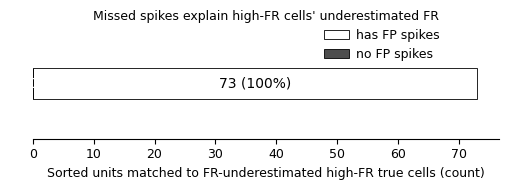

In [10]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_with_fn_spike,
            n_without_fn_spike,
        ],
    },
    index=["has FP spikes", "no FP spikes"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["k", "w"]
percents = [percent_with_fn_spikes, percent_without_fn_spikes]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units matched to FR-underestimated high-FR true cells (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("Missed spikes explain high-FR cells' underestimated FR", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    ax.text(
        x + width / 2,
        y + height / 2,
        "{:.0f} ({:.0f}%)".format(width, percents[p_i]*100),
        horizontalalignment="center",
        verticalalignment="center",
        color=txt_colors[p_i],
    )

In [24]:
out["MatchingObject"].get_redundant_units(redundant_score=0)

[11, 34, 37, 273, 296]

In [26]:
oversplit_units = out["MatchingObject"].get_redundant_units()

# count the overmerging conditions
n_oversplit = len(set(oversplit_units) & set(cell_matching["sorted_cell"][underestimated_higher_frs]))
n_not_oversplit = n_total - n_oversplit
percent_oversplit = n_oversplit/n_total*100
percent_not_oversplit = n_not_oversplit/n_total*100

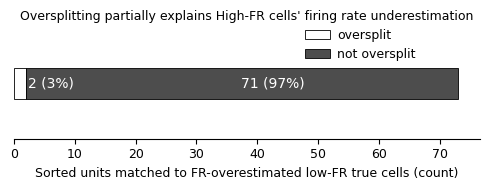

In [51]:
from matplotlib import pyplot as plt

# build histo dataset
data_df = pd.DataFrame(
    {
        "cell count": [
            n_oversplit,
            n_not_oversplit,
        ],
    },
    index=["oversplit", "not oversplit"],
)

# set figure
fig, axis = plt.subplots(1, 1, figsize=(5, 2))

# set plot legend
colors = ["w", [0.3, 0.3, 0.3]]
txt_colors = ["w", "w"]
percents = [percent_oversplit, percent_not_oversplit]

# plot
ax = data_df.T.plot.barh(
    ax=axis,
    stacked=True,
    color=colors,
    width=0.2,
    edgecolor="k",
    linewidth=0.6,
)

# set axis legend
ax.spines[["left", "right", "top"]].set_visible(False)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(True)
y_axis = ax.axes.get_yaxis()
y_axis.set_visible(False)
ax.set_xlabel("Sorted units matched to FR-overestimated low-FR true cells (count)", fontsize=9)
ax.legend(
    bbox_to_anchor=(0.6, 0.6),
    frameon=False,
    fontsize=9,
    handletextpad=0.6,
)
ax.set_title("Oversplitting partially explains High-FR cells' firing rate underestimation", fontsize=9)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.tight_layout()

# annotate bars with count by sorting error type
x_shift = 5
for p_i, patch in enumerate(ax.patches):
    width, height = patch.get_width(), patch.get_height()
    x, y = patch.get_xy()
    if not width==0:
        ax.text(
            x + width / 2 + x_shift,
            y + height / 2,
            "{:.0f} ({:.0f}%)".format(width, percents[p_i]),
            horizontalalignment="center",
            verticalalignment="center",
            color=txt_colors[p_i],
    )

Overmerged units have an agreement score above 0.2 with two or more ground-truth units [Buccino et al., 2020, p. 16].

In [34]:
print("oversplitting score:", out["MatchingObject"].redundant_score)
out["MatchingObject"].get_redundant_units()

oversplitting score: 0


[11, 34, 37, 273, 296]

# references

https://spikeinterface.readthedocs.io/en/latest/modules/comparison.html#more-information-about-hungarian-or-best-match-methods